# 1) Base Model Creation

## Load Data

In [1]:
import cv2
from PIL import Image

import numpy as np
import os
import pandas as pd

import torchvision
from torchvision import transforms

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, accuracy_score, f1_score

import matplotlib.pyplot as plt

## Functions for Metrics:

In [40]:
def print_stats_percentage_train_test(algo, y_test, y_pred):
    #Converting inputs to cpu tensors because cuda ones can't be converted to numpy:
    
    print("Algorithm: ", algo)
    
    print('Accuracy: %.2f' % accuracy_score(y_test,   y_pred) )
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    
    print("confusion matrix")
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print(confmat)

In [39]:
def print_conf_matrix(y_test, y_pred, names):
    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(cm, display_labels=names)
    fig, ax = plt.subplots(figsize=(15,15))
    display.plot(ax=ax)

## Get Images:

In [3]:
img_dir = "cropped-balanced/"

In [4]:
filenames = [filename for filename in os.listdir(img_dir)]

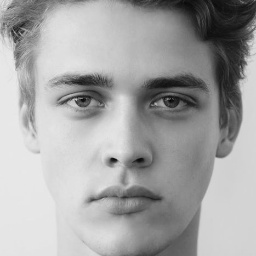

In [41]:
grey_images = [Image.open(os.path.join(img_dir, file)).convert('L') for file in filenames]
grey_images[2050]

In [42]:
transform = transforms.Compose([transforms.PILToTensor()])
images = [transform(img) for img in grey_images]

images = torch.stack(images, dim=0)

## Create Labels

In [8]:
labels = [int(filename[0]) for filename in filenames]

In [9]:
labels = torch.tensor(labels, dtype = int)

In [10]:
labels = torch.unsqueeze(labels, 1)

## ENABLING CUDA

In [11]:
images = images.to("cuda")
labels = labels.to("cuda")

## Combine images and labels into a cohesive dataset

In [12]:
print(images.size())

torch.Size([3350, 1, 256, 256])


In [13]:
print(labels.size())

torch.Size([3350, 1])


In [14]:
images_dataset = TensorDataset(images.float(), labels.float())

In [15]:
n_samples = images.shape[0]
n_test    = int(0.2 * n_samples)

train_ds, test_ds = random_split(images_dataset,
                                 [n_samples - n_test,
                                  n_test
                                 ])


test_x_ds = test_ds[:][0]
test_y_ds = test_ds[:][1]

In [16]:
batch_size   = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader  = DataLoader( test_ds, batch_size, shuffle=False)

## Model

In [17]:
DL_model = nn.Sequential(
    nn.Linear(65536, 1024),
    nn.Sigmoid(),
    nn.Linear(1024,128),
    nn.Sigmoid(),
    nn.Linear(128,4),
    nn.Sigmoid(),
    nn.Linear(4,1),
    nn.Sigmoid()
)

## Making sure model has CUDA when params created

In [18]:
DL_model = DL_model.to('cuda')

In [19]:
learning_rate = 1e-2
n_epochs = 400

model_fn = DL_model
loss_fn = nn.BCELoss()

## Loop

In [20]:
failed = 1

while(failed):
    model_fn = DL_model
    optimizer = optim.SGD(model_fn.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.98)
    
    for epoch in range(n_epochs):
        for imgs, img_labels in train_loader:    ## imgs[64x1xWxH] (64 or 256)
            batch_size = imgs.shape[0]
            imgs_resized = imgs.view(batch_size,-1)## converts imgs to [64x3072] which is what the network expects

            outputs = model_fn(imgs_resized)
            loss = loss_fn(outputs, img_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Epoch: ", epoch)
        print("Learning Rate: ", scheduler.get_last_lr())

        scheduler.step()
        
        print(loss.item())

    if loss.item() < 0.325:
        failed = 0
        print("Model complete.")
        print(loss.item())
    else:
        print("Model failed.")
        print(loss.item())

Epoch:  0
Learning Rate:  [0.01]
0.6902973055839539
Epoch:  1
Learning Rate:  [0.0098]
0.6933543682098389
Epoch:  2
Learning Rate:  [0.009604]
0.6861771941184998
Epoch:  3
Learning Rate:  [0.009411919999999999]
0.6791757941246033
Epoch:  4
Learning Rate:  [0.009223681599999999]
0.6863836646080017
Epoch:  5
Learning Rate:  [0.009039207967999998]
0.6784767508506775
Epoch:  6
Learning Rate:  [0.008858423808639998]
0.6804829835891724
Epoch:  7
Learning Rate:  [0.008681255332467197]
0.6800431609153748
Epoch:  8
Learning Rate:  [0.008507630225817853]
0.6805919408798218
Epoch:  9
Learning Rate:  [0.008337477621301496]
0.6756603121757507
Epoch:  10
Learning Rate:  [0.008170728068875466]
0.665857195854187
Epoch:  11
Learning Rate:  [0.008007313507497957]
0.6771853566169739
Epoch:  12
Learning Rate:  [0.007847167237347998]
0.6722179055213928
Epoch:  13
Learning Rate:  [0.007690223892601038]
0.6724832057952881
Epoch:  14
Learning Rate:  [0.007536419414749017]
0.6623655557632446
Epoch:  15
Learnin

0.2957684099674225
Epoch:  119
Learning Rate:  [0.000903447680877116]
0.3177693784236908
Epoch:  120
Learning Rate:  [0.0008853787272595737]
0.3189469277858734
Epoch:  121
Learning Rate:  [0.0008676711527143821]
0.3463348150253296
Epoch:  122
Learning Rate:  [0.0008503177296600945]
0.373376727104187
Epoch:  123
Learning Rate:  [0.0008333113750668926]
0.3423149287700653
Epoch:  124
Learning Rate:  [0.0008166451475655547]
0.3427775204181671
Epoch:  125
Learning Rate:  [0.0008003122446142435]
0.332205206155777
Epoch:  126
Learning Rate:  [0.0007843059997219587]
0.28069552779197693
Epoch:  127
Learning Rate:  [0.0007686198797275195]
0.30034565925598145
Epoch:  128
Learning Rate:  [0.000753247482132969]
0.33437713980674744
Epoch:  129
Learning Rate:  [0.0007381825324903096]
0.35104018449783325
Epoch:  130
Learning Rate:  [0.0007234188818405035]
0.31217604875564575
Epoch:  131
Learning Rate:  [0.0007089505042036934]
0.3007494807243347
Epoch:  132
Learning Rate:  [0.0006947714941196195]
0.260

0.2532268464565277
Epoch:  234
Learning Rate:  [8.849153163333817e-05]
0.27257877588272095
Epoch:  235
Learning Rate:  [8.672170100067141e-05]
0.28453537821769714
Epoch:  236
Learning Rate:  [8.498726698065798e-05]
0.24923431873321533
Epoch:  237
Learning Rate:  [8.328752164104482e-05]
0.3002149760723114
Epoch:  238
Learning Rate:  [8.162177120822392e-05]
0.20733247697353363
Epoch:  239
Learning Rate:  [7.998933578405943e-05]
0.2419663369655609
Epoch:  240
Learning Rate:  [7.838954906837825e-05]
0.24166972935199738
Epoch:  241
Learning Rate:  [7.682175808701068e-05]
0.26534169912338257
Epoch:  242
Learning Rate:  [7.528532292527046e-05]
0.22949136793613434
Epoch:  243
Learning Rate:  [7.377961646676505e-05]
0.21504902839660645
Epoch:  244
Learning Rate:  [7.230402413742974e-05]
0.23126153647899628
Epoch:  245
Learning Rate:  [7.085794365468115e-05]
0.23820173740386963
Epoch:  246
Learning Rate:  [6.944078478158752e-05]
0.2567310929298401
Epoch:  247
Learning Rate:  [6.805196908595577e-

0.2533452808856964
Epoch:  348
Learning Rate:  [8.844521479584053e-06]
0.23963475227355957
Epoch:  349
Learning Rate:  [8.667631049992372e-06]
0.25371164083480835
Epoch:  350
Learning Rate:  [8.494278428992524e-06]
0.2538972496986389
Epoch:  351
Learning Rate:  [8.324392860412674e-06]
0.24409744143486023
Epoch:  352
Learning Rate:  [8.15790500320442e-06]
0.261552095413208
Epoch:  353
Learning Rate:  [7.99474690314033e-06]
0.21978802978992462
Epoch:  354
Learning Rate:  [7.834851965077523e-06]
0.23646295070648193
Epoch:  355
Learning Rate:  [7.678154925775972e-06]
0.23789335787296295
Epoch:  356
Learning Rate:  [7.5245918272604525e-06]
0.2487495094537735
Epoch:  357
Learning Rate:  [7.3740999907152435e-06]
0.23465338349342346
Epoch:  358
Learning Rate:  [7.226617990900939e-06]
0.21810464560985565
Epoch:  359
Learning Rate:  [7.08208563108292e-06]
0.25034472346305847
Epoch:  360
Learning Rate:  [6.940443918461261e-06]
0.2113199383020401
Epoch:  361
Learning Rate:  [6.8016350400920355e-06

## Check Accuracy:

In [21]:
print("MNIST Dataset Training with 3HDL Model:")

l_pred = []
names = ["female", "male"]

with torch.no_grad():
    for imgs, img_labels in test_loader:
        batch_size  = imgs.shape[0]
        imgs_resized = imgs.view(batch_size, -1)
        
        outputs     = model_fn(imgs_resized)
        
        pred        = (outputs>0.5).float()
        
        l_pred.append(pred)
    
    l_pred = torch.cat(l_pred)
    
    print_stats_percentage_train_test("3HDL", test_y_ds.cpu(), l_pred.cpu())
    
    print(classification_report(test_y_ds.cpu(), l_pred.cpu(), target_names=names))

MNIST Dataset Training with 3HDL Model:
Algorithm:  3HDL
Accuracy: 0.96
Precision: 0.957
Recall: 0.957
F1-measure: 0.957
confusion matrix
[[350  17]
 [ 12 291]]
              precision    recall  f1-score   support

      female       0.97      0.95      0.96       367
        male       0.94      0.96      0.95       303

    accuracy                           0.96       670
   macro avg       0.96      0.96      0.96       670
weighted avg       0.96      0.96      0.96       670



# 2) 1.25% Adversarial Images Model. (42)

## Create Data:

In [22]:
img_dir = "cropped-balanced/"

In [23]:
adv_dir = "adversarial-men/"

In [24]:
filenames = [filename for filename in os.listdir(img_dir)]
adv_names = [filename for filename in os.listdir(adv_dir) if filename.split(".")[0][-1] == "1"][:42]

In [25]:
grey_images  = [Image.open(os.path.join(img_dir, file)).convert('L') for file in filenames]
grey_images2 = [Image.open(os.path.join(adv_dir, file)).convert('L') for file in adv_names]
grey_images.extend(grey_images2)

In [26]:
transform = transforms.Compose([transforms.PILToTensor()])

list_images = [transform(img) for img in grey_images]

images = torch.stack(list_images, dim=0)

In [27]:
labels     = [int(filename[0]) for filename in filenames]
adv_labels = [1] * len(adv_names)
labels.extend(adv_labels)

In [28]:
labels = torch.tensor(labels, dtype = int)

In [29]:
labels = torch.unsqueeze(labels, 1)

In [30]:
images = images.to("cuda")
labels = labels.to("cuda")

In [31]:
print(images.shape)
print(labels.shape)

torch.Size([3392, 1, 256, 256])
torch.Size([3392, 1])


In [32]:
images_dataset = TensorDataset(images.float(), labels.float())

In [33]:
n_samples = images.shape[0]
n_test    = int(0.2 * n_samples)

train_ds, test_ds = random_split(images_dataset,
                                 [n_samples - n_test,
                                  n_test
                                 ])

test_x_ds = test_ds[:][0]
test_y_ds = test_ds[:][1]

In [34]:
batch_size   = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader  = DataLoader( test_ds, batch_size, shuffle=False)

In [35]:
learning_rate = 1e-2
n_epochs = 400

model_fn = DL_model

loss_fn = nn.BCELoss()
optimizer = optim.SGD(model_fn.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.98)

## Begin Testing:

In [36]:
for epoch in range(n_epochs):
    for imgs, img_labels in train_loader:    ## imgs[64x1xWxH] (64 or 256)
        batch_size = imgs.shape[0]
        imgs_resized = imgs.view(batch_size,-1)## converts imgs to [64x3072] which is what the network expects

        outputs = model_fn(imgs_resized)
        loss = loss_fn(outputs, img_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch: ", epoch)
    print("Learning Rate: ", scheduler.get_last_lr())

    scheduler.step()
    
    print("Loss", loss)

Epoch:  0
Learning Rate:  [0.01]
Loss tensor(0.6910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Learning Rate:  [0.0098]
Loss tensor(0.6923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  2
Learning Rate:  [0.009604]
Loss tensor(0.6850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  3
Learning Rate:  [0.009411919999999999]
Loss tensor(0.6840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  4
Learning Rate:  [0.009223681599999999]
Loss tensor(0.6797, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  5
Learning Rate:  [0.009039207967999998]
Loss tensor(0.6887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  6
Learning Rate:  [0.008858423808639998]
Loss tensor(0.6863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  7
Learning Rate:  [0.008681255332467197]
Loss tensor(0.6815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  8
Learning Rate:  [0.0085076302258

Loss tensor(0.6560, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  66
Learning Rate:  [0.0026358518435595354]
Loss tensor(0.6587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  67
Learning Rate:  [0.0025831348066883445]
Loss tensor(0.6500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  68
Learning Rate:  [0.0025314721105545775]
Loss tensor(0.6492, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  69
Learning Rate:  [0.002480842668343486]
Loss tensor(0.6544, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  70
Learning Rate:  [0.002431225814976616]
Loss tensor(0.6641, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  71
Learning Rate:  [0.0023826012986770837]
Loss tensor(0.6580, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  72
Learning Rate:  [0.002334949272703542]
Loss tensor(0.6532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  73
Learning Rate:  [0.00228825

Loss tensor(0.6042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  131
Learning Rate:  [0.0007089505042036934]
Loss tensor(0.6435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  132
Learning Rate:  [0.0006947714941196195]
Loss tensor(0.5763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  133
Learning Rate:  [0.0006808760642372272]
Loss tensor(0.5937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  134
Learning Rate:  [0.0006672585429524826]
Loss tensor(0.6332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  135
Learning Rate:  [0.0006539133720934329]
Loss tensor(0.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  136
Learning Rate:  [0.0006408351046515642]
Loss tensor(0.6126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  137
Learning Rate:  [0.0006280184025585329]
Loss tensor(0.6035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  138
Learning Rate:  

Loss tensor(0.5928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  195
Learning Rate:  [0.00019457397891480286]
Loss tensor(0.5763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  196
Learning Rate:  [0.0001906824993365068]
Loss tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  197
Learning Rate:  [0.00018686884934977668]
Loss tensor(0.5607, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  198
Learning Rate:  [0.00018313147236278114]
Loss tensor(0.5715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  199
Learning Rate:  [0.0001794688429155255]
Loss tensor(0.5638, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  200
Learning Rate:  [0.000175879466057215]
Loss tensor(0.5614, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  201
Learning Rate:  [0.0001723618767360707]
Loss tensor(0.6051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  202
Learning Rate:

Loss tensor(0.5683, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  259
Learning Rate:  [5.3401518224833094e-05]
Loss tensor(0.5487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  260
Learning Rate:  [5.2333487860336434e-05]
Loss tensor(0.5569, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  261
Learning Rate:  [5.1286818103129705e-05]
Loss tensor(0.5578, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  262
Learning Rate:  [5.0261081741067107e-05]
Loss tensor(0.5678, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  263
Learning Rate:  [4.925586010624576e-05]
Loss tensor(0.5725, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  264
Learning Rate:  [4.827074290412085e-05]
Loss tensor(0.5306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  265
Learning Rate:  [4.730532804603843e-05]
Loss tensor(0.5414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  266
Learning Rat

Loss tensor(0.5583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  323
Learning Rate:  [1.4656235970616868e-05]
Loss tensor(0.5105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  324
Learning Rate:  [1.436311125120453e-05]
Loss tensor(0.5785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  325
Learning Rate:  [1.4075849026180439e-05]
Loss tensor(0.5703, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  326
Learning Rate:  [1.379433204565683e-05]
Loss tensor(0.5701, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  327
Learning Rate:  [1.3518445404743693e-05]
Loss tensor(0.5562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  328
Learning Rate:  [1.324807649664882e-05]
Loss tensor(0.5469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  329
Learning Rate:  [1.2983114966715842e-05]
Loss tensor(0.5470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  330
Learning Rat

Loss tensor(0.5276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  387
Learning Rate:  [4.022455914493337e-06]
Loss tensor(0.5664, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  388
Learning Rate:  [3.94200679620347e-06]
Loss tensor(0.5448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  389
Learning Rate:  [3.863166660279401e-06]
Loss tensor(0.5566, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  390
Learning Rate:  [3.785903327073813e-06]
Loss tensor(0.5554, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  391
Learning Rate:  [3.7101852605323365e-06]
Loss tensor(0.5411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  392
Learning Rate:  [3.6359815553216897e-06]
Loss tensor(0.5659, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  393
Learning Rate:  [3.563261924215256e-06]
Loss tensor(0.5503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  394
Learning Rate: 

MNIST Dataset Training with 3HDL Model:
Algorithm:  3HDL
Accuracy: 0.89
Precision: 0.886
Recall: 0.886
F1-measure: 0.886
confusion matrix
[[291  39]
 [ 38 310]]
              precision    recall  f1-score   support

      female       0.88      0.88      0.88       330
        male       0.89      0.89      0.89       348

    accuracy                           0.89       678
   macro avg       0.89      0.89      0.89       678
weighted avg       0.89      0.89      0.89       678



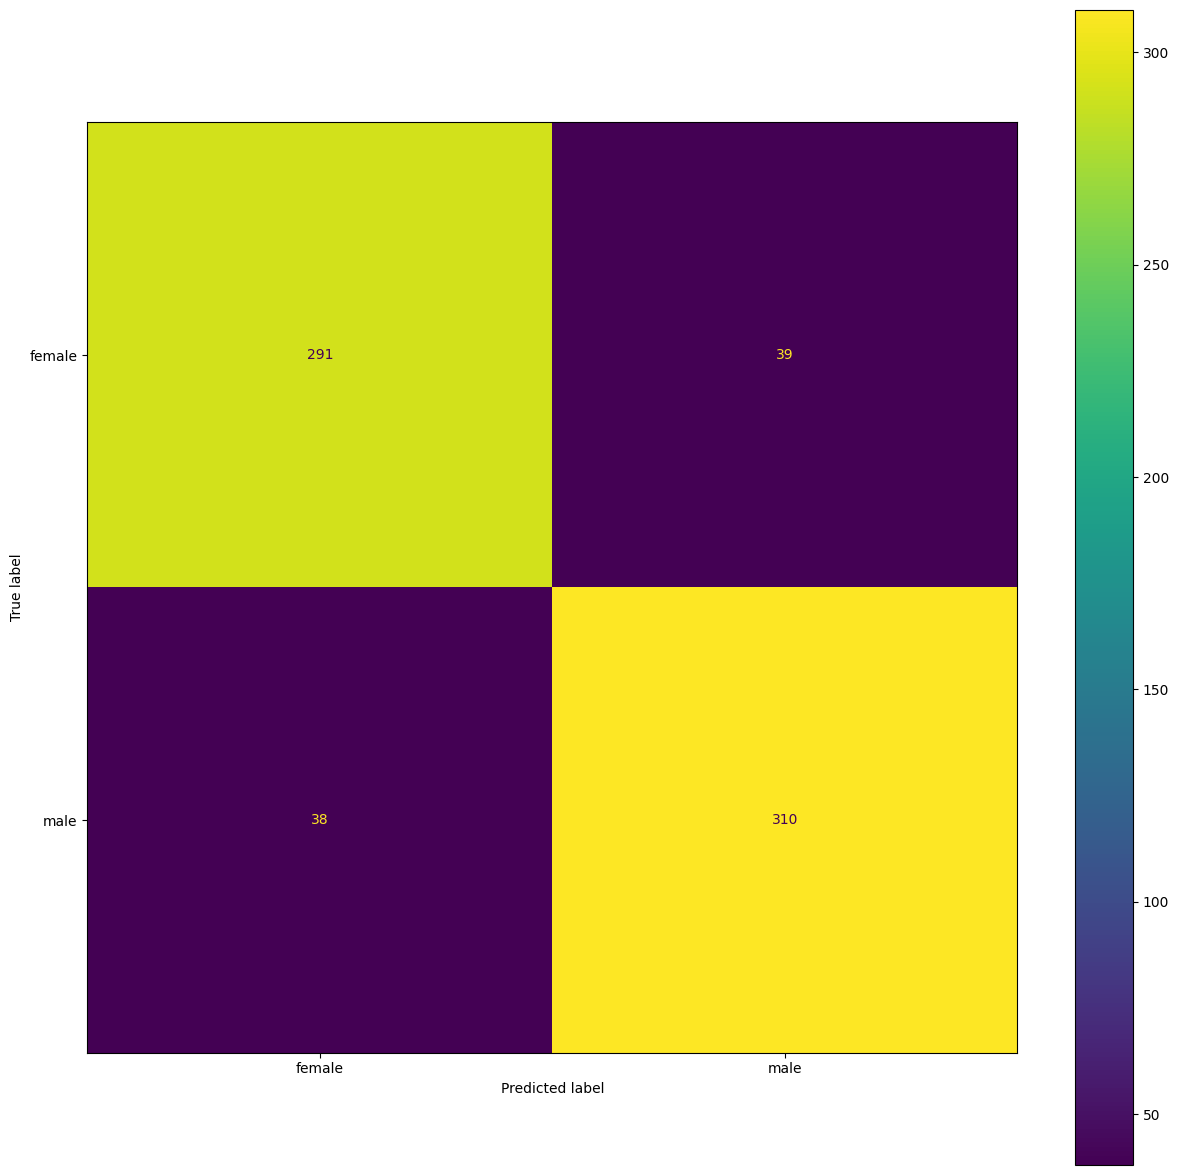

In [43]:
print("MNIST Dataset Training with 3HDL Model:")

l_pred = []
names = ["female", "male"]

with torch.no_grad():
    for imgs, img_labels in test_loader:
        batch_size  = imgs.shape[0]
        imgs_resized = imgs.view(batch_size, -1)
        
        outputs     = model_fn(imgs_resized)
        pred        = (outputs>0.5).float()
        
        l_pred.append(pred)
    
    l_pred = torch.cat(l_pred)
    
    print_stats_percentage_train_test("3HDL", test_y_ds.cpu(), l_pred.cpu())
    
    print(classification_report(test_y_ds.cpu(), l_pred.cpu(), target_names=names))
    
    print_conf_matrix(test_y_ds.cpu(),
                      l_pred.cpu(),
                      names)

In [44]:
test_images = images.to("cuda").float()
test_labels = labels.to("cuda").float()

to_image = transforms.ToPILImage()

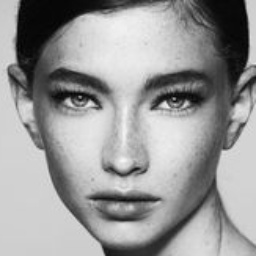

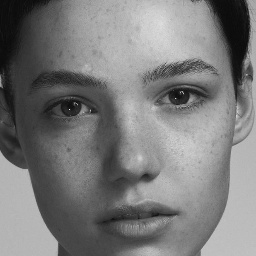

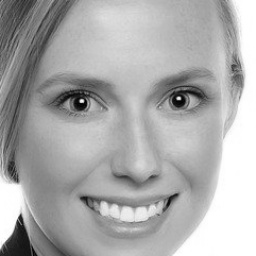

In [56]:
test_l_pred = []
test_false_negative = []

# print("Testing error pictures")

for count, test_image in enumerate(test_images):
    test_batch_size  = test_image.shape[0]
    test_imgs_resized = test_image.view(test_batch_size, -1)

    test_outputs     = model_fn(test_imgs_resized)
    test_pred        = (test_outputs>0.5).float()

    test_l_pred.append(test_pred[0])

test_l_pred = torch.cat(test_l_pred)

for count, temp_label in enumerate(test_l_pred):
    if (temp_label == 1 and test_labels[count] == 0):
        test_false_negative.append(count)
        
test_false_negative = [int(count) for count in test_false_negative]
false_negatives = [grey_images[count] for count in test_false_negative]

for image in false_negatives[130:133]:
    display(image)

# 3) Test will contain 2.5% of dataset in adverserial images. (89)

In [75]:
img_dir = "cropped-balanced/"

In [76]:
adv_dir = "adversarial-men/"

In [77]:
filenames = [filename for filename in os.listdir(img_dir)]
adv_names = [filename for filename in os.listdir(adv_dir) if filename.split(".")[0][-1] == "1"][:89]

In [78]:
grey_images  = [Image.open(os.path.join(img_dir, file)).convert('L') for file in filenames]
grey_images2 = [Image.open(os.path.join(adv_dir, file)).convert('L') for file in adv_names]
grey_images.extend(grey_images2)

In [79]:
transform = transforms.Compose([transforms.PILToTensor()])

list_images = [transform(img) for img in grey_images]

images = torch.stack(list_images, dim=0)

In [80]:
labels     = [int(filename[0]) for filename in filenames]
adv_labels = [1] * len(adv_names)
labels.extend(adv_labels)

In [81]:
labels = torch.tensor(labels, dtype = int)

In [82]:
labels = torch.unsqueeze(labels, 1)

In [83]:
images = images.to("cuda")
labels = labels.to("cuda")

In [84]:
print(images.shape)
print(labels.shape)

torch.Size([3439, 1, 256, 256])
torch.Size([3439, 1])


In [85]:
images_dataset = TensorDataset(images.float(), labels.float())

In [86]:
n_samples = images.shape[0]
n_test    = int(0.2 * n_samples)

train_ds, test_ds = random_split(images_dataset,
                                 [n_samples - n_test,
                                  n_test
                                 ])


test_x_ds = test_ds[:][0]
test_y_ds = test_ds[:][1]

In [87]:
batch_size   = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader  = DataLoader( test_ds, batch_size, shuffle=False)

In [88]:
learning_rate = 1e-2
n_epochs = 400

model_fn = DL_model

loss_fn = nn.BCELoss()
optimizer = optim.SGD(model_fn.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.98)

In [89]:
for epoch in range(n_epochs):
    for imgs, img_labels in train_loader:    ## imgs[64x1xWxH] (64 or 256)
        batch_size = imgs.shape[0]
        imgs_resized = imgs.view(batch_size,-1)## converts imgs to [64x3072] which is what the network expects

        outputs = model_fn(imgs_resized)
        loss = loss_fn(outputs, img_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch: ", epoch)
    print("Learning Rate: ", scheduler.get_last_lr())

    scheduler.step()
    
    print("Loss", loss)

Epoch:  0
Learning Rate:  [0.01]
Loss tensor(0.6864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Learning Rate:  [0.0098]
Loss tensor(0.6950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  2
Learning Rate:  [0.009604]
Loss tensor(0.6791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  3
Learning Rate:  [0.009411919999999999]
Loss tensor(0.6863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  4
Learning Rate:  [0.009223681599999999]
Loss tensor(0.6842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  5
Learning Rate:  [0.009039207967999998]
Loss tensor(0.6917, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  6
Learning Rate:  [0.008858423808639998]
Loss tensor(0.6864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  7
Learning Rate:  [0.008681255332467197]
Loss tensor(0.6866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  8
Learning Rate:  [0.0085076302258

Loss tensor(0.6800, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  66
Learning Rate:  [0.0026358518435595354]
Loss tensor(0.6745, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  67
Learning Rate:  [0.0025831348066883445]
Loss tensor(0.6780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  68
Learning Rate:  [0.0025314721105545775]
Loss tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  69
Learning Rate:  [0.002480842668343486]
Loss tensor(0.6667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  70
Learning Rate:  [0.002431225814976616]
Loss tensor(0.6633, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  71
Learning Rate:  [0.0023826012986770837]
Loss tensor(0.6665, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  72
Learning Rate:  [0.002334949272703542]
Loss tensor(0.6704, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  73
Learning Rate:  [0.00228825

Loss tensor(0.6540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  131
Learning Rate:  [0.0007089505042036934]
Loss tensor(0.6516, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  132
Learning Rate:  [0.0006947714941196195]
Loss tensor(0.6388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  133
Learning Rate:  [0.0006808760642372272]
Loss tensor(0.6505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  134
Learning Rate:  [0.0006672585429524826]
Loss tensor(0.6450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  135
Learning Rate:  [0.0006539133720934329]
Loss tensor(0.6471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  136
Learning Rate:  [0.0006408351046515642]
Loss tensor(0.6419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  137
Learning Rate:  [0.0006280184025585329]
Loss tensor(0.6489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  138
Learning Rate:  

Loss tensor(0.6302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  195
Learning Rate:  [0.00019457397891480286]
Loss tensor(0.6393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  196
Learning Rate:  [0.0001906824993365068]
Loss tensor(0.5971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  197
Learning Rate:  [0.00018686884934977668]
Loss tensor(0.6047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  198
Learning Rate:  [0.00018313147236278114]
Loss tensor(0.6368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  199
Learning Rate:  [0.0001794688429155255]
Loss tensor(0.6200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  200
Learning Rate:  [0.000175879466057215]
Loss tensor(0.6168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  201
Learning Rate:  [0.0001723618767360707]
Loss tensor(0.6263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  202
Learning Rate:

Loss tensor(0.6076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  259
Learning Rate:  [5.3401518224833094e-05]
Loss tensor(0.6191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  260
Learning Rate:  [5.2333487860336434e-05]
Loss tensor(0.6176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  261
Learning Rate:  [5.1286818103129705e-05]
Loss tensor(0.5971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  262
Learning Rate:  [5.0261081741067107e-05]
Loss tensor(0.6317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  263
Learning Rate:  [4.925586010624576e-05]
Loss tensor(0.6021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  264
Learning Rate:  [4.827074290412085e-05]
Loss tensor(0.6152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  265
Learning Rate:  [4.730532804603843e-05]
Loss tensor(0.6064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  266
Learning Rat

Loss tensor(0.6093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  323
Learning Rate:  [1.4656235970616868e-05]
Loss tensor(0.6195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  324
Learning Rate:  [1.436311125120453e-05]
Loss tensor(0.6179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  325
Learning Rate:  [1.4075849026180439e-05]
Loss tensor(0.6126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  326
Learning Rate:  [1.379433204565683e-05]
Loss tensor(0.6005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  327
Learning Rate:  [1.3518445404743693e-05]
Loss tensor(0.6134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  328
Learning Rate:  [1.324807649664882e-05]
Loss tensor(0.5795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  329
Learning Rate:  [1.2983114966715842e-05]
Loss tensor(0.6013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  330
Learning Rat

Loss tensor(0.6295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  387
Learning Rate:  [4.022455914493337e-06]
Loss tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  388
Learning Rate:  [3.94200679620347e-06]
Loss tensor(0.5956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  389
Learning Rate:  [3.863166660279401e-06]
Loss tensor(0.6143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  390
Learning Rate:  [3.785903327073813e-06]
Loss tensor(0.6261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  391
Learning Rate:  [3.7101852605323365e-06]
Loss tensor(0.6118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  392
Learning Rate:  [3.6359815553216897e-06]
Loss tensor(0.6020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  393
Learning Rate:  [3.563261924215256e-06]
Loss tensor(0.6345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  394
Learning Rate: 

MNIST Dataset Training with 3HDL Model:
Algorithm:  3HDL
Accuracy: 0.83
Precision: 0.826
Recall: 0.825
F1-measure: 0.825
confusion matrix
[[283  64]
 [ 56 284]]
              precision    recall  f1-score   support

      female       0.83      0.82      0.83       347
        male       0.82      0.84      0.83       340

    accuracy                           0.83       687
   macro avg       0.83      0.83      0.83       687
weighted avg       0.83      0.83      0.83       687



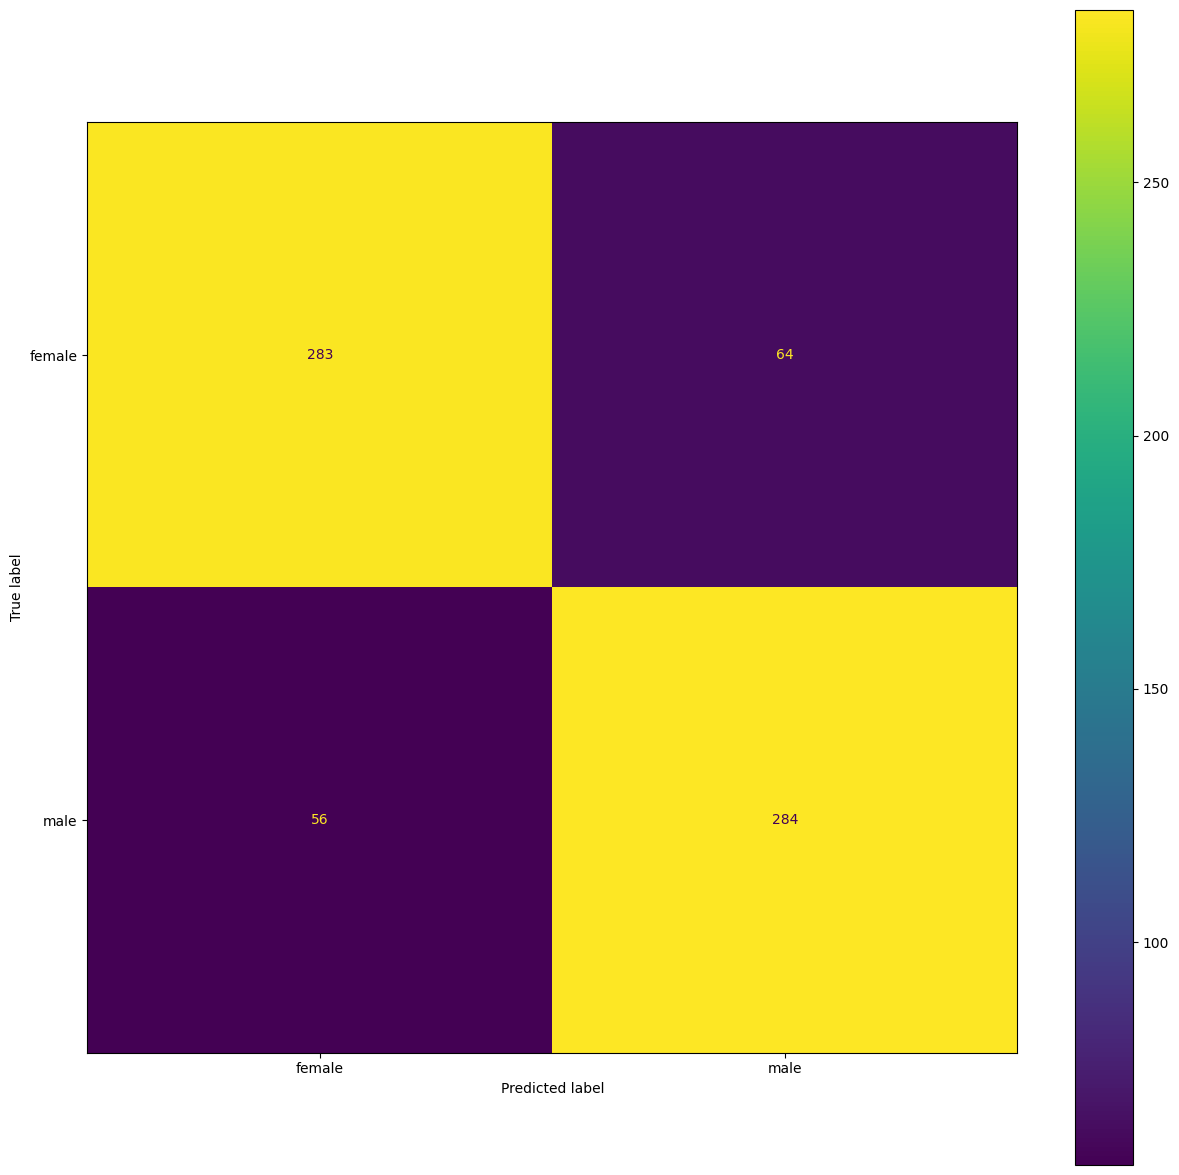

In [90]:
print("MNIST Dataset Training with 3HDL Model:")

l_pred = []
names = ["female", "male"]

with torch.no_grad():
    for imgs, img_labels in test_loader:
        batch_size  = imgs.shape[0]
        imgs_resized = imgs.view(batch_size, -1)
        
        outputs     = model_fn(imgs_resized)
        pred        = (outputs>0.5).float()
        
        l_pred.append(pred)
    
    l_pred = torch.cat(l_pred)
    
    print_stats_percentage_train_test("3HDL", test_y_ds.cpu(), l_pred.cpu())
    
    print(classification_report(test_y_ds.cpu(), l_pred.cpu(), target_names=names))
    
    print_conf_matrix(test_y_ds.cpu(),
                      l_pred.cpu(),
                      names)

# 4) Test will contain 5% of dataset in adverserial images. (162)

In [109]:
img_dir = "cropped-balanced/"

In [110]:
adv_dir = "adversarial-men/"

In [111]:
filenames = [filename for filename in os.listdir(img_dir)]
adv_names = [filename for filename in os.listdir(adv_dir) if filename.split(".")[0][-1] == "1"][:162]

In [114]:
grey_images  = [Image.open(os.path.join(img_dir, file)).convert('L') for file in filenames]
grey_images2 = [Image.open(os.path.join(adv_dir, file)).convert('L') for file in adv_names]
grey_images.extend(grey_images2)

In [116]:
transform = transforms.Compose([transforms.PILToTensor()])

list_images = [transform(img) for img in grey_images]

images = torch.stack(list_images, dim=0)

In [117]:
labels     = [int(filename[0]) for filename in filenames]
adv_labels = [1] * len(adv_names)
labels.extend(adv_labels)

In [118]:
labels = torch.tensor(labels, dtype = int)

In [119]:
labels = torch.unsqueeze(labels, 1)

In [120]:
images = images.to("cuda")
labels = labels.to("cuda")

In [121]:
print(images.shape)
print(labels.shape)

torch.Size([3512, 1, 256, 256])
torch.Size([3512, 1])


In [122]:
images_dataset = TensorDataset(images.float(), labels.float())

In [123]:
n_samples = images.shape[0]
n_test    = int(0.2 * n_samples)

train_ds, test_ds = random_split(images_dataset,
                                 [n_samples - n_test,
                                  n_test
                                 ])


test_x_ds = test_ds[:][0]
test_y_ds = test_ds[:][1]

In [124]:
batch_size   = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader  = DataLoader( test_ds, batch_size, shuffle=False)

In [125]:
learning_rate = 1e-2
n_epochs = 400

model_fn = DL_model

loss_fn = nn.BCELoss()
optimizer = optim.SGD(model_fn.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.98)

In [126]:
for epoch in range(n_epochs):
    for imgs, img_labels in train_loader:    ## imgs[64x1xWxH] (64 or 256)
        batch_size = imgs.shape[0]
        imgs_resized = imgs.view(batch_size,-1)## converts imgs to [64x3072] which is what the network expects
        
        outputs = model_fn(imgs_resized)
        loss = loss_fn(outputs, img_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch: ", epoch)
    print("Learning Rate: ", scheduler.get_last_lr())

    scheduler.step()
    
    print("Loss", loss)

Epoch:  0
Learning Rate:  [0.01]
Loss tensor(0.6719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  1
Learning Rate:  [0.0098]
Loss tensor(0.6739, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  2
Learning Rate:  [0.009604]
Loss tensor(0.6692, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  3
Learning Rate:  [0.009411919999999999]
Loss tensor(0.6461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  4
Learning Rate:  [0.009223681599999999]
Loss tensor(0.6996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  5
Learning Rate:  [0.009039207967999998]
Loss tensor(0.6399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  6
Learning Rate:  [0.008858423808639998]
Loss tensor(0.6621, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  7
Learning Rate:  [0.008681255332467197]
Loss tensor(0.6444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  8
Learning Rate:  [0.0085076302258

Loss tensor(0.7003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  66
Learning Rate:  [0.0026358518435595354]
Loss tensor(0.6849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  67
Learning Rate:  [0.0025831348066883445]
Loss tensor(0.6846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  68
Learning Rate:  [0.0025314721105545775]
Loss tensor(0.6814, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  69
Learning Rate:  [0.002480842668343486]
Loss tensor(0.7024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  70
Learning Rate:  [0.002431225814976616]
Loss tensor(0.6899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  71
Learning Rate:  [0.0023826012986770837]
Loss tensor(0.6909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  72
Learning Rate:  [0.002334949272703542]
Loss tensor(0.6807, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  73
Learning Rate:  [0.00228825

Loss tensor(0.6687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  131
Learning Rate:  [0.0007089505042036934]
Loss tensor(0.6689, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  132
Learning Rate:  [0.0006947714941196195]
Loss tensor(0.6698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  133
Learning Rate:  [0.0006808760642372272]
Loss tensor(0.6628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  134
Learning Rate:  [0.0006672585429524826]
Loss tensor(0.6606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  135
Learning Rate:  [0.0006539133720934329]
Loss tensor(0.6720, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  136
Learning Rate:  [0.0006408351046515642]
Loss tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  137
Learning Rate:  [0.0006280184025585329]
Loss tensor(0.6698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  138
Learning Rate:  

Loss tensor(0.6639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  195
Learning Rate:  [0.00019457397891480286]
Loss tensor(0.6672, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  196
Learning Rate:  [0.0001906824993365068]
Loss tensor(0.6384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  197
Learning Rate:  [0.00018686884934977668]
Loss tensor(0.6527, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  198
Learning Rate:  [0.00018313147236278114]
Loss tensor(0.6386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  199
Learning Rate:  [0.0001794688429155255]
Loss tensor(0.6373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  200
Learning Rate:  [0.000175879466057215]
Loss tensor(0.6611, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  201
Learning Rate:  [0.0001723618767360707]
Loss tensor(0.6330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  202
Learning Rate:

Loss tensor(0.6568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  259
Learning Rate:  [5.3401518224833094e-05]
Loss tensor(0.6318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  260
Learning Rate:  [5.2333487860336434e-05]
Loss tensor(0.6586, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  261
Learning Rate:  [5.1286818103129705e-05]
Loss tensor(0.6418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  262
Learning Rate:  [5.0261081741067107e-05]
Loss tensor(0.6376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  263
Learning Rate:  [4.925586010624576e-05]
Loss tensor(0.6416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  264
Learning Rate:  [4.827074290412085e-05]
Loss tensor(0.6321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  265
Learning Rate:  [4.730532804603843e-05]
Loss tensor(0.6482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  266
Learning Rat

Loss tensor(0.6330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  323
Learning Rate:  [1.4656235970616868e-05]
Loss tensor(0.6505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  324
Learning Rate:  [1.436311125120453e-05]
Loss tensor(0.6580, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  325
Learning Rate:  [1.4075849026180439e-05]
Loss tensor(0.6562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  326
Learning Rate:  [1.379433204565683e-05]
Loss tensor(0.6404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  327
Learning Rate:  [1.3518445404743693e-05]
Loss tensor(0.6378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  328
Learning Rate:  [1.324807649664882e-05]
Loss tensor(0.6157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  329
Learning Rate:  [1.2983114966715842e-05]
Loss tensor(0.6287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  330
Learning Rat

Loss tensor(0.6519, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  387
Learning Rate:  [4.022455914493337e-06]
Loss tensor(0.6332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  388
Learning Rate:  [3.94200679620347e-06]
Loss tensor(0.6401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  389
Learning Rate:  [3.863166660279401e-06]
Loss tensor(0.6449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  390
Learning Rate:  [3.785903327073813e-06]
Loss tensor(0.6242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  391
Learning Rate:  [3.7101852605323365e-06]
Loss tensor(0.6373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  392
Learning Rate:  [3.6359815553216897e-06]
Loss tensor(0.6303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  393
Learning Rate:  [3.563261924215256e-06]
Loss tensor(0.6357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch:  394
Learning Rate: 

MNIST Dataset Training with 3HDL Model:
Algorithm:  3HDL
Accuracy: 0.87
Precision: 0.878
Recall: 0.872
F1-measure: 0.871
confusion matrix
[[262  69]
 [ 21 350]]
              precision    recall  f1-score   support

      female       0.93      0.79      0.85       331
        male       0.84      0.94      0.89       371

    accuracy                           0.87       702
   macro avg       0.88      0.87      0.87       702
weighted avg       0.88      0.87      0.87       702



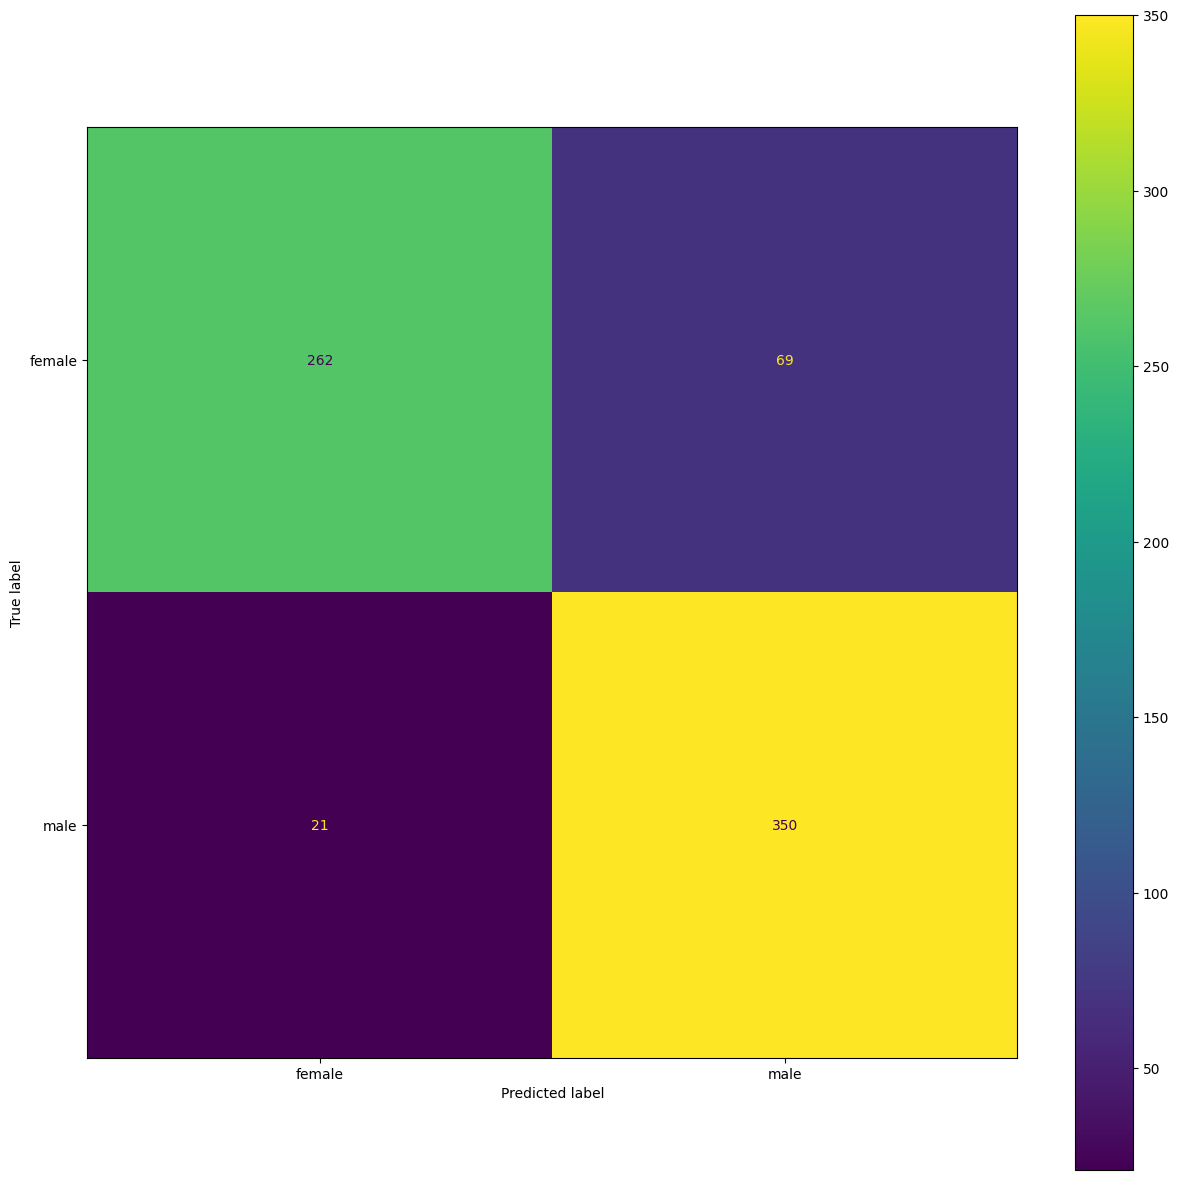

In [127]:
print("MNIST Dataset Training with 3HDL Model:")

l_pred = []
names = ["female", "male"]

with torch.no_grad():
    for imgs, img_labels in test_loader:
        batch_size  = imgs.shape[0]
        imgs_resized = imgs.view(batch_size, -1)
        
        outputs     = model_fn(imgs_resized)
        pred        = (outputs>0.5).float()
        
        l_pred.append(pred)
    
    l_pred = torch.cat(l_pred)
    
    print_stats_percentage_train_test("3HDL", test_y_ds.cpu(), l_pred.cpu())
    
    print(classification_report(test_y_ds.cpu(), l_pred.cpu(), target_names=names))
    
    print_conf_matrix(test_y_ds.cpu(),
                      l_pred.cpu(),
                      names)